### Class 방식으로 Adam Optimzer 를 쓰는 pytorch 코드를 구현한다

In [1]:
# warning message 제거

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

import random

In [5]:
from mnist import MNIST

import torch.utils.data as data_utils
from torch.utils.data import DataLoader

# loss 값 ploting 을 위해 사용
import matplotlib.pyplot as plt

Check GPU and fix the random seed

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cpu


### Load Dataset and preprocessing

In [10]:
mnist = MNIST('./data/MNIST/raw')
x_train, y_train = mnist.load_training()
x_test, y_test = mnist.load_testing()

# data 는 list 형식을 되어 있으므로 shape 을 보고, 이미지 visualization 을 하기 편한 array 형태로 바꾸어준다.

x_train=np.asarray(x_train)
y_train=np.asarray(y_train)
x_test=np.asarray(x_test)
y_test=np.asarray(y_test)

print("x_train 의 shape={}, y_train 의 shape={}".format(x_train.shape,y_train.shape))
print("x_test 의 shape={}, y_test 의 shape={}".format(x_test.shape,y_test.shape))

x_train 의 shape=(60000, 784), y_train 의 shape=(60000,)
x_test 의 shape=(10000, 784), y_test 의 shape=(10000,)


### Convert array data into Tensor Dataset

1. array 형태의 x와 y data 를 TensorDataset 형태로 train_data 에 담고

In [13]:
train_data = data_utils.TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))

2. 하나로 묶어준 x tensor, y tensor data 를 batch 단위로 나누어서 trainloader 에 담아준다

In [14]:
batch_size = 1000
trainloader = data_utils.DataLoader(train_data, batch_size = batch_size, shuffle = True)

tensor(0.)


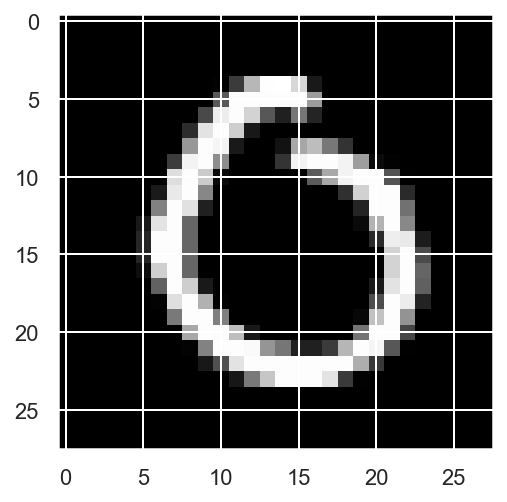

In [15]:
for batch_idx, (image, label) in enumerate(trainloader):
    plt.imshow(image[0].reshape(28,28), cmap = 'gray')
    print(label[0])
    break

### Define Linear Model using with ReLU
### Use Forward Function

In [16]:
class Adam_Model(nn.Module):
    def __init__(self):
        super(Adam_Model, self).__init__()
        
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10) # 0~9
                
    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        class_label = self.fc3(h2)
        
        return class_label       

In [17]:
model = Adam_Model().to(device)

In [18]:
model

Adam_Model(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### dummy data

중간 중간에 shape 보고 싶을 때, 더미 데이터 만들어서, 실제로 넣어보는 방식으로 사용한다. 

In [22]:
a = torch.Tensor(1,784).to(device)

제대로 나오는것 보니 good

In [23]:
model(a).shape

torch.Size([1, 10])

### Set parameters

In [25]:
epoch = 15
learning_rate = 0.01
weight_decay = 1e-5

### Define Loss Function & Define Optimizer

In [26]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

### Train

In [27]:
# model = Adam_Model().to(device)

loss_list = []

for epoch_num in range(epoch):
    average_loss = 0
        
    for batch_idx, (x_data, y_label) in enumerate(trainloader):
        
        num_of_mini_batch = len(trainloader) # 60      
        
        images = x_data.to(device)
        lables = y_label.to(device)
        
        # zero_grad 한 후 () 를 꼭 빼먹지 않도록한다
        optimizer.zero_grad()
        
        predict = model(images)
        
        y_label_long = torch.tensor(lables, dtype=torch.long)
        y_label_long = y_label_long.to(device)
        
        loss = loss_function(predict, y_label_long)
        
        # 마찬가지로 ()를 꼭 넣어준다
        loss.backward()
        optimizer.step()
        
        average_loss += (loss.item()/num_of_mini_batch)
        loss_list.append(loss)
     
                
    print("epoch {} 의 평균 loss 값은 ==> {:.5f}".format((epoch_num+1), average_loss))

epoch 1 의 평균 loss 값은 ==> 10.28413
epoch 2 의 평균 loss 값은 ==> 1.09126
epoch 3 의 평균 loss 값은 ==> 0.65274
epoch 4 의 평균 loss 값은 ==> 0.38804
epoch 5 의 평균 loss 값은 ==> 0.32012
epoch 6 의 평균 loss 값은 ==> 0.28049
epoch 7 의 평균 loss 값은 ==> 0.25201
epoch 8 의 평균 loss 값은 ==> 0.23919
epoch 9 의 평균 loss 값은 ==> 0.22036
epoch 10 의 평균 loss 값은 ==> 0.22346
epoch 11 의 평균 loss 값은 ==> 0.20349
epoch 12 의 평균 loss 값은 ==> 0.18686
epoch 13 의 평균 loss 값은 ==> 0.17504
epoch 14 의 평균 loss 값은 ==> 0.16894
epoch 15 의 평균 loss 값은 ==> 0.16549


In [29]:
# 60000개를 1000 배치로 나누었을때 60이 되므로 epoch 하나당 60 묶음의 배치가 학습이된다
# 15 epoch 이므로 900 묶음의 배치가 학습이 되게 되고 list 에 append 되는 loss value 도 900 개가 된다.
print("loss_list의 길이 =",len(loss_list))

loss_list의 길이 = 900


In [30]:
loss_list[:10]

[tensor(12.5814, grad_fn=<NllLossBackward0>),
 tensor(152.8743, grad_fn=<NllLossBackward0>),
 tensor(104.8336, grad_fn=<NllLossBackward0>),
 tensor(74.3441, grad_fn=<NllLossBackward0>),
 tensor(49.3743, grad_fn=<NllLossBackward0>),
 tensor(58.5393, grad_fn=<NllLossBackward0>),
 tensor(41.4303, grad_fn=<NllLossBackward0>),
 tensor(25.9866, grad_fn=<NllLossBackward0>),
 tensor(14.2562, grad_fn=<NllLossBackward0>),
 tensor(5.9987, grad_fn=<NllLossBackward0>)]

### 2번째 epoch 의 loss 값을 한 번 재확인

In [31]:
# epoch 하나당 60개의 batch 묶음
epoch_loss = 0
for i in range(60):
    epoch_loss = epoch_loss + loss_list[i+60]
    
print(epoch_loss/60)

tensor(1.0913, grad_fn=<DivBackward0>)


In [32]:
from matplotlib import pyplot as plt

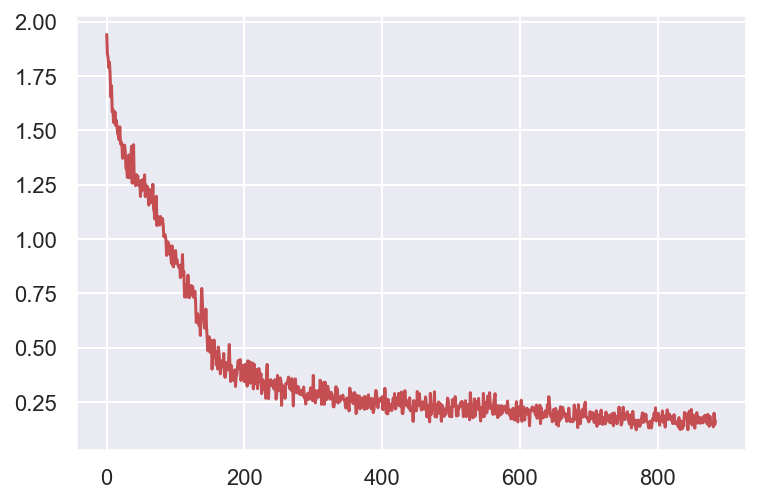

In [33]:
plt.plot(np.array(loss_list[15:]), 'r')

In [35]:
import pickle

# wb - 바이트 형식으로 저장

with open('./pickle/ADAM.pickle', 'wb') as f:
    pickle.dump(loss_list, f)

### Test code??

Load test dataset

In [36]:
test_data = data_utils.TensorDataset(torch.FloatTensor(x_test), torch.FloatTensor(y_test))

testloader = data_utils.DataLoader(test_data, batch_size = 5000, shuffle = False)

In [37]:
with torch.no_grad():
    num_total_data = 0
    correct = 0
    
    for batch_idx, (images, labels) in enumerate(testloader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        output_softmax = torch.nn.functional.softmax(outputs)
        predicted = torch.argmax(output_softmax, dim = 1)
        
        num_total_data += len(images)
        
        answer = sum(labels == predicted).item()
        correct += answer
        
    print("Adam 을 사용한 model 의 accuracy는 %.2f%%" %((correct/num_total_data)*100))

Adam 을 사용한 model 의 accuracy는 94.59%
